In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# netcdf with Nans create a lot of misc warnings when you decode them
import warnings
warnings.filterwarnings('ignore')

In [3]:
def list_experiments(path, variableName="cVeg"):
    exps = set()
    for filename in os.listdir(path):
        if filename.startswith(variableName):
            #print(filename)
            exps.add(filename.split("_")[2])
    return exps


def load(path, variableName="cVeg", experiment="CanESM5"):
    experimentfiles = []
    for filename in os.listdir(path):
        if filename.startswith(variableName + "_") and filename.split("_")[2].lower() == experiment.lower():
            experimentfiles.append(path + filename)
    
    experimentfiles.sort()
    nplist = []
    
    for filename in experimentfiles:
        arr = xr.open_dataset(filename)[variableName].to_numpy()
        nplist.append(arr)

    final = np.concatenate(nplist)    
    return final    

In [4]:
start_x = 12*(0) # 1850
end_x = 12*(25) # 1875
start_y = 12*(75) # 1925
end_y = 12*(100) # 1950

def avg20(ds):
    return np.mean(ds, axis=0) # axis of mean = time

def std20(ds):
    return np.std(ds, axis=0)

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def globe(ax, imagedata, **kwargs):
    imageshape = imagedata.shape
    half1 = imagedata[:,imageshape[1]//2:]
    half2 = imagedata[:,:imageshape[1]//2]
    
    
    #imagedata = imagedata[:,:imageshape[0]//2]
    #return ax.imshow(imagedata, **kwargs)
    return ax.imshow(np.concatenate([half1, half2],axis=1), **kwargs)

# Here Be Dragons...
def fit_and_test(inputs, output, masks, test_inputs, test_output, title=""):
    modelshape = inputs[0].shape

    predicted_present = np.full(modelshape, np.nan)
    predicted_future = np.full(modelshape, np.nan)

    cmip_present = np.full(modelshape, np.nan)
    cmip_future = np.full(modelshape, np.nan)

    labels = ["Tropics", "Extratropics"]
    maskidx = 0
    fig = plt.figure()
    
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Precipitation')
    ax.set_zlabel('MSE')

    for mask in masks:
        # Prepare and mask inputs/outputs for linreg
        model_inputs = inputs[:,mask]#.flatten()
        model_test_inputs = test_inputs[:,mask]#.flatten()
        
        model_inputs = np.array(model_inputs).transpose()
        model_test_inputs = np.array(model_test_inputs).transpose()
        
        model_output = output[mask].flatten()
        model_test_output = test_output[mask].flatten()
    
        # Fit and score model
        model = LinearRegression()
        model.fit(model_inputs, model_output)
    
        R2_present = model.score(model_inputs, model_output)
        R2_future = model.score(model_test_inputs, model_test_output)

        linear_outputs = model.predict(model_inputs) 
        linear_test_outputs = model.predict(model_test_inputs)

        mse = (model_output - linear_outputs)**2
        mse_test = (model_test_output - linear_test_outputs)**2

        ax.scatter(model_inputs[:,0],model_inputs[:,1],mse)
        #ax.scatter(model_inputs[0,:],model_inputs[1,:],mse_test)
        
        
        #print(title, "*", model.coef_, "+", model.intercept_)
        
        #print(title, labels[maskidx], "Adjusted Coefficients", model.coef_[0] * np.std(inputs[0,mask]), model.coef_[1] * np.std(inputs[1,mask]), model.coef_[2] * np.std(inputs[2,mask]), "+",model.intercept_)
        #print(title, labels[maskidx], "Adjusted Intercept", model.intercept_ + (model.coef_[0] * np.mean(inputs[0,mask])) + (model.coef_[1] * np.mean(inputs[1,mask])) + (model.coef_[2] * np.mean(inputs[2,mask])))
        
        #print(np.std(inputs[0,mask]), np.std(inputs[1,mask]), np.std(inputs[2,mask]))
        
        #print(title, "R^2 Present", R2_present)
        print(title, "R^2 Future", R2_future) 
        
        predicted_present[mask] = linear_outputs
        predicted_future[mask] = linear_test_outputs
    
        cmip_present[mask] = model_output  
        cmip_future[mask] = model_test_output
        maskidx += 1

    #plt.savefig('figure_'+title+"subplot"+'.png')

    # Setup plots
    fig, axs = plt.subplots(3, 3, figsize=(36, 18)) #+ 4 * len(inputs)))
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.tight_layout()
    fig.suptitle(title)
    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")
    axs[0][2].set_title("Difference")
    
    axs[0][0].set_ylabel("CMIP")
    globe(axs[0][0], cmip_present[::-1], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    #pcm0 = axs[0][1].imshow(cmip_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])
    pcm0 = globe(axs[0][1], cmip_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    
    axs[1][0].set_ylabel("Predicted")
    globe(axs[1][0], predicted_present[::-1], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    pcm1 = globe(axs[1][1], predicted_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    cbar1 = fig.colorbar(pcm1, ax=[axs[0][0], axs[0][1], axs[1][0], axs[1][1]], shrink=0.5, location='left')
    cbar1.ax.set_ylabel("cVeg (kg/m^2)")
    
    #axs[2][0].set_ylabel("Residuals")
    #axs[2][0].imshow(predicted_present[::-1] - cmip_present[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #pcm2 = axs[2][1].imshow(predicted_future[::-1] - cmip_future[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #fig.colorbar(pcm2, ax=[axs[2][0],axs[2][1]], shrink=0.5)

    pcmr1 = globe(axs[0][2], cmip_future[::-1] - cmip_present[::-1], vmin=-3, vmax=3, cmap="coolwarm", interpolation='none', extent=[-180,180,-90,90])
    pcmr2 = globe(axs[1][2], predicted_future[::-1] - predicted_present[::-1], vmin=-3, vmax=3, cmap="coolwarm", interpolation='none', extent=[-180,180,-90,90])
    cbar2 = fig.colorbar(pcmr1, ax=[axs[0,2],axs[1,2]], shrink=0.5)
    cbar2.ax.set_ylabel("cVeg (kg/m^2)")

    globalmask = masks[0] | masks[1]

    labels = ["Temperature" , "Precipitation", "VPD"]
    bounds = [10,2.5*1e-5,1]
    
    for i in range(2):
        inputs[i][~globalmask] = np.nan
        test_inputs[i][~globalmask] = np.nan
        
        axs[2][i].set_title(labels[i] + " change 50yrs")
        pcminp = globe(axs[2][i], test_inputs[i][::-1] - inputs[i][::-1], cmap="Spectral", vmin=-bounds[i],vmax=bounds[i], extent=[-180,180,-90,90])
        fig.colorbar(pcminp, ax=axs[2][i], shrink=0.5)
    
    #plt.savefig('figure_'+title+'.png')
    
    
    return model

In [7]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
print(getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64)))

def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

0.9999999999999999


<Figure size 1200x400 with 0 Axes>

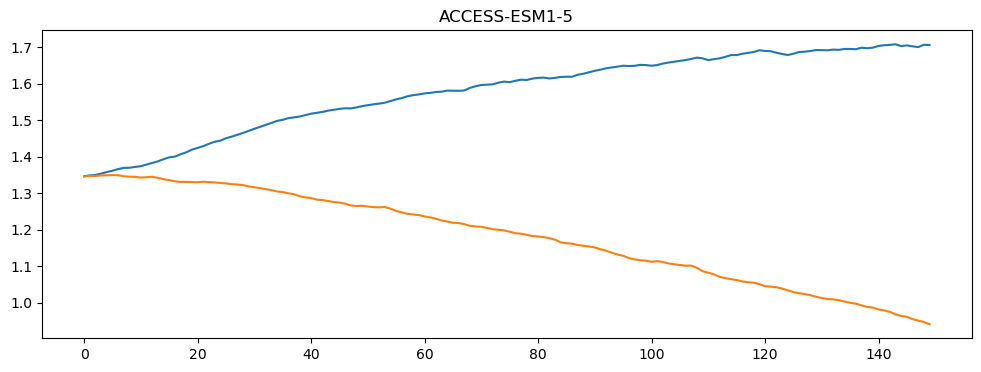

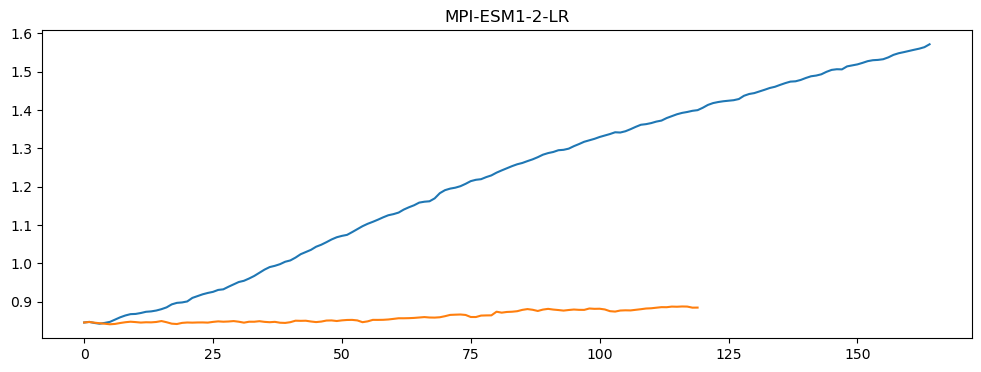

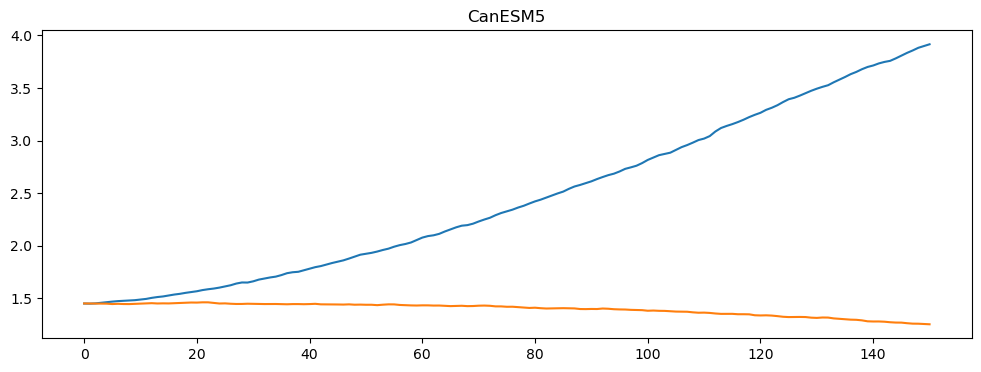

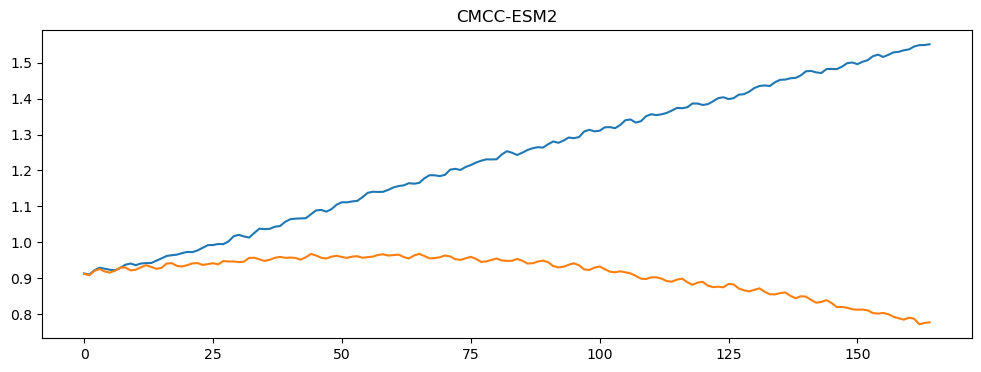

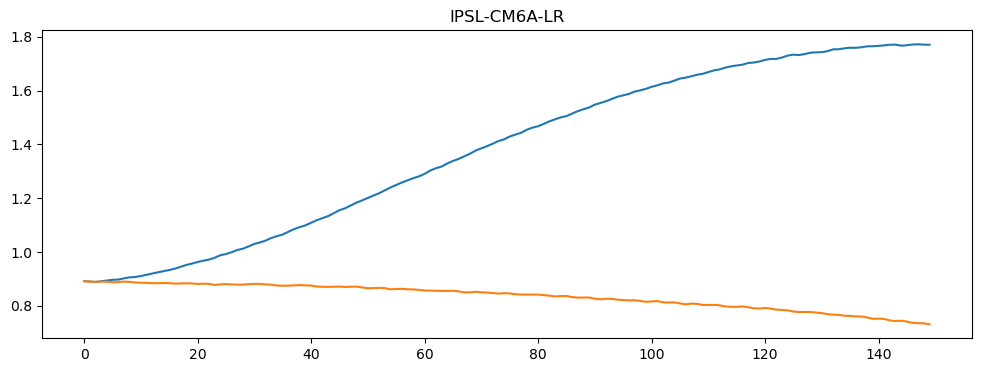

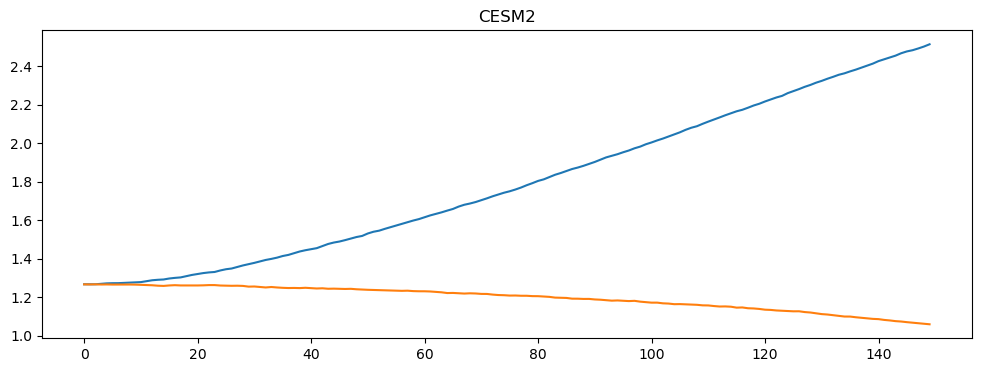

In [8]:
def timeseries(values, name="", fig=plt.figure(figsize=(12,4))):
    weights = cuts(values.shape[1],values.shape[2])
    
    values = np.nan_to_num(values)
    monthly = np.sum(values * weights, axis=(1,2))
    yearly = np.mean(monthly.reshape(-1, 12), axis=1)
    
    plt.plot(yearly)
    plt.title(name)

for expname in list_experiments("./1pctCO2/","cVeg"):
    fig = plt.figure(figsize=(12,4))
    timeseries(load("./1pctCO2/","cVeg", expname), expname, fig)
    timeseries(load("./1pctCO2-rad/","cVeg", expname), expname, fig)    

In [9]:
def vpd(ts, hurs):
    ts_c = ts - 273.15
    vpsat = 6.1094 * np.exp(17.625 * ts_c / (ts_c + 243.04)) # in hPa, from claus-clap wikipedia page
    #plt.imshow(vpsat)
    #plt.colorbar()

    vpd = (vpsat/10) * ((100-hurs)/100) # from vpd wikipedia page, unit shouldnt matter because scaler * percent?
    return vpd

CMCC-ESM2 Future 1pctCO2 R^2 Future 0.46209800243377686
CMCC-ESM2 Future 1pctCO2 R^2 Future 0.31832271814346313
MPI-ESM1-2-LR Future 1pctCO2 R^2 Future 0.7931326627731323
MPI-ESM1-2-LR Future 1pctCO2 R^2 Future 0.25071853399276733
CanESM5 Future 1pctCO2 R^2 Future 0.6992753744125366
CanESM5 Future 1pctCO2 R^2 Future 0.4374381899833679
GFDL-ESM4 Future 1pctCO2 R^2 Future 0.3718421459197998
GFDL-ESM4 Future 1pctCO2 R^2 Future 0.41185086965560913
CESM2 Future 1pctCO2 R^2 Future 0.6531895399093628
CESM2 Future 1pctCO2 R^2 Future 0.30840325355529785
IPSL-CM6A-LR Future 1pctCO2 R^2 Future 0.5327249765396118
IPSL-CM6A-LR Future 1pctCO2 R^2 Future 0.355979859828949
ACCESS-ESM1-5 Future 1pctCO2 R^2 Future 0.5313178300857544
ACCESS-ESM1-5 Future 1pctCO2 R^2 Future 0.2795739769935608


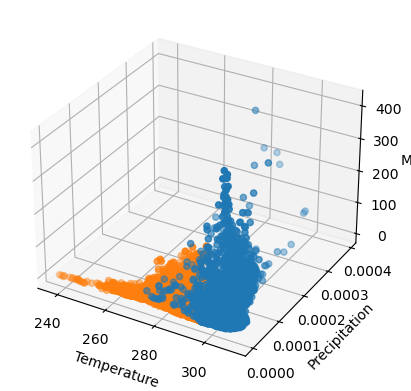

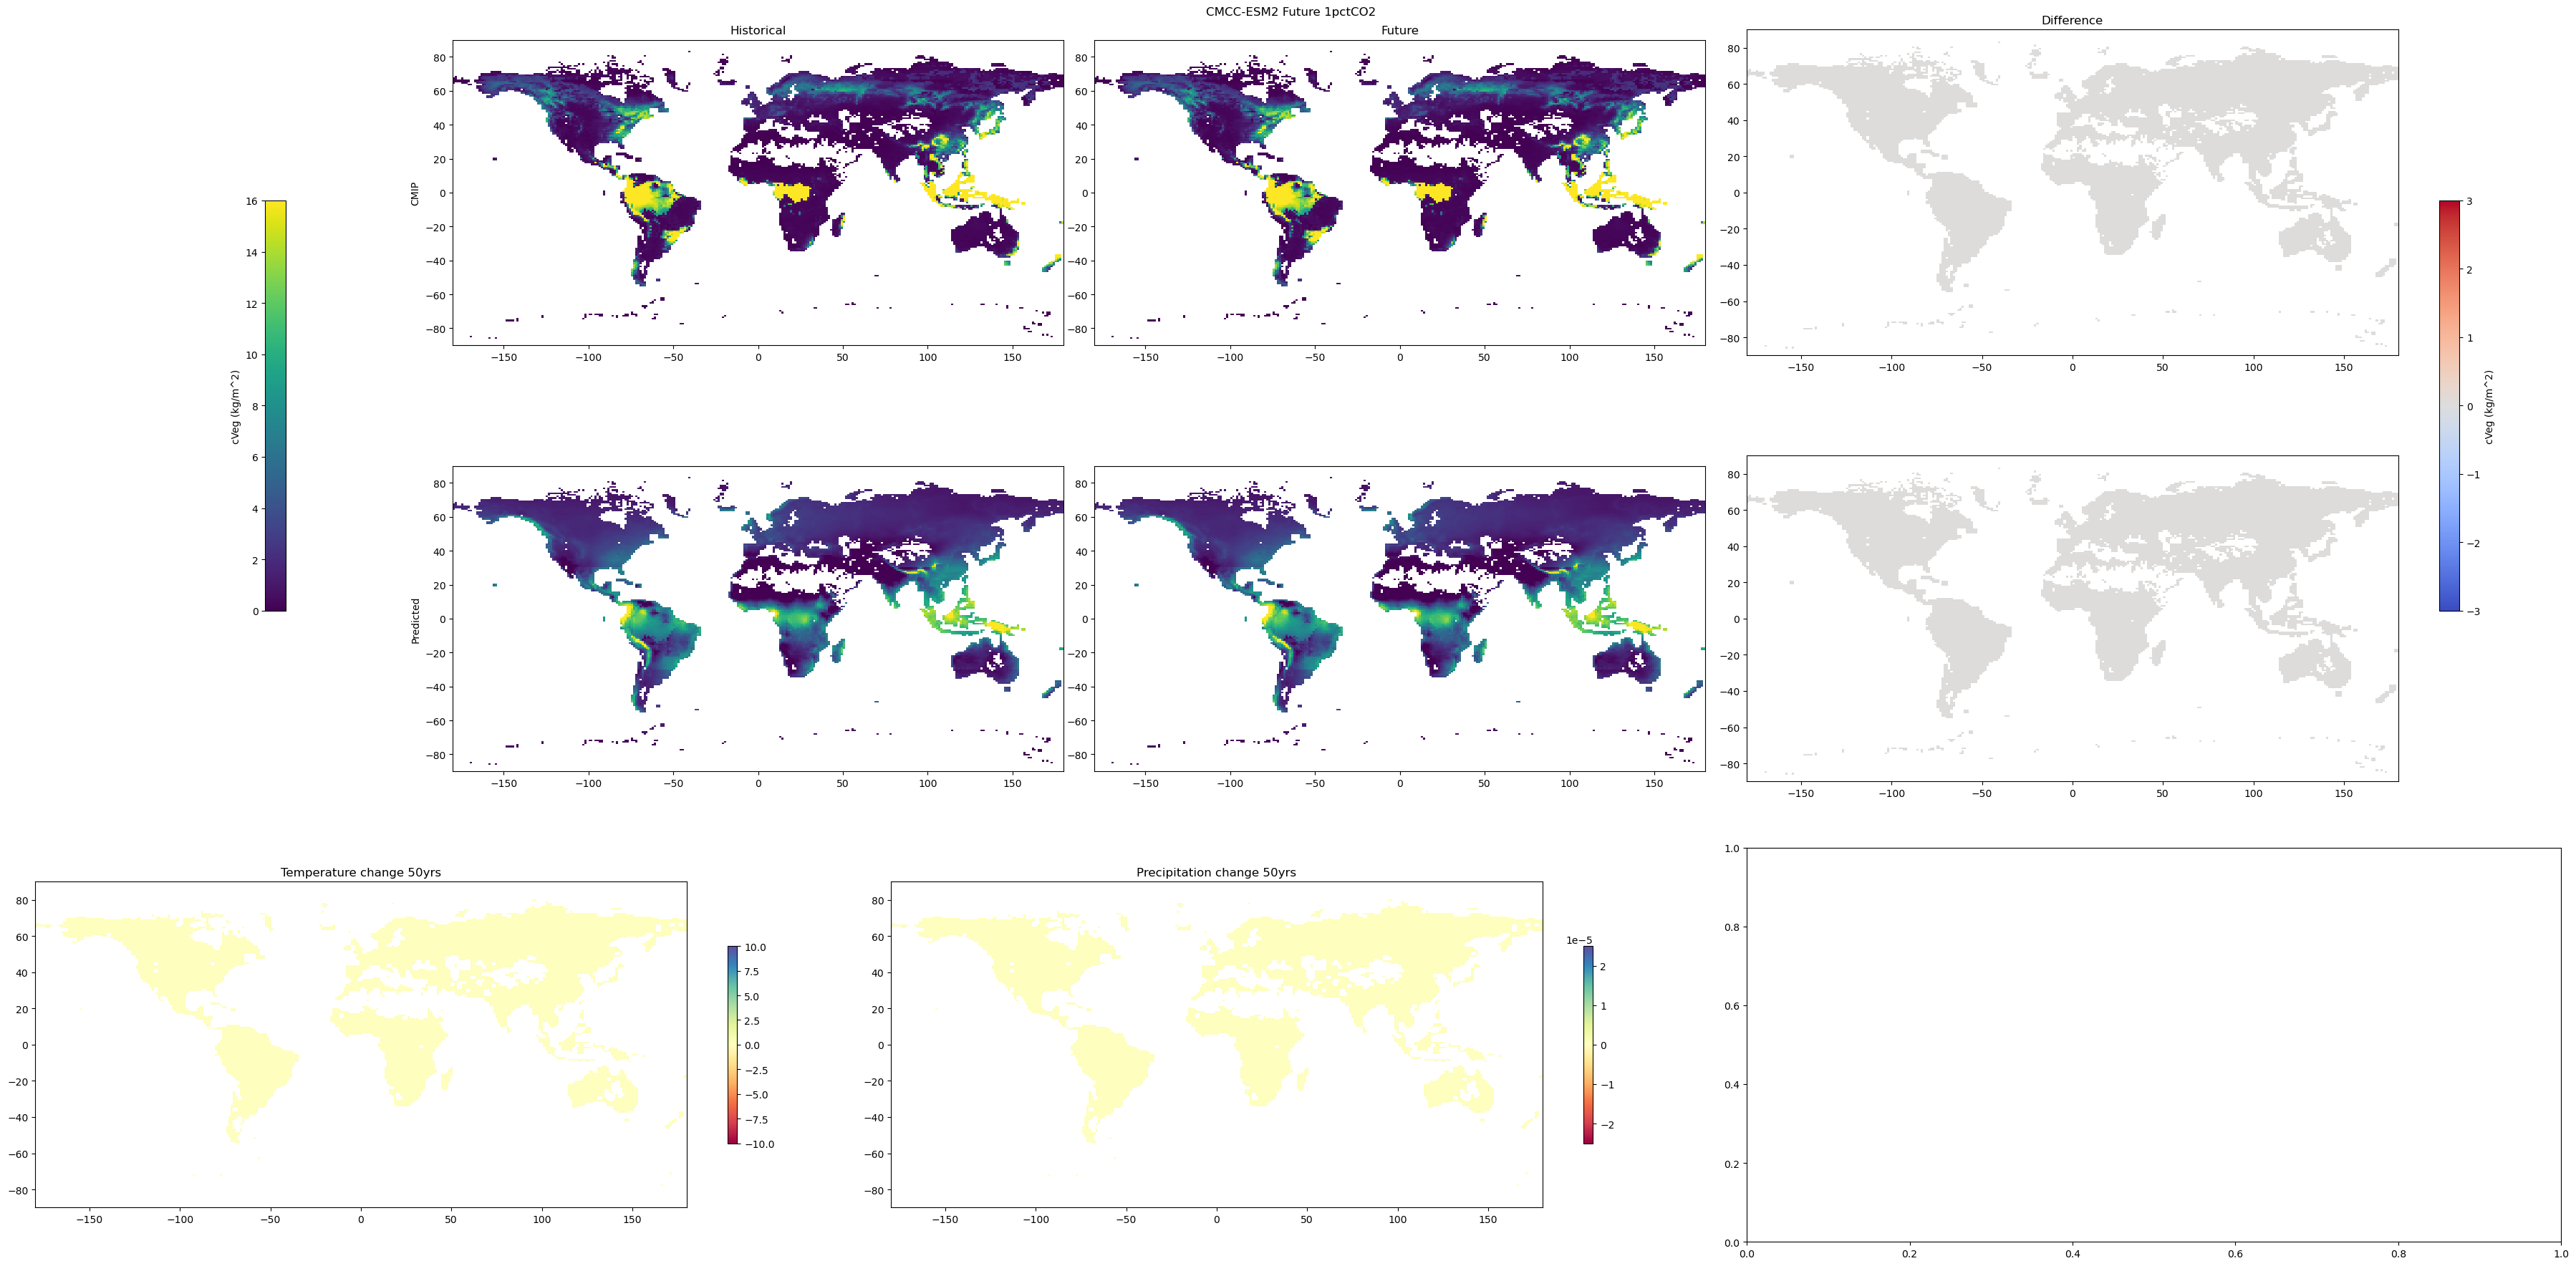

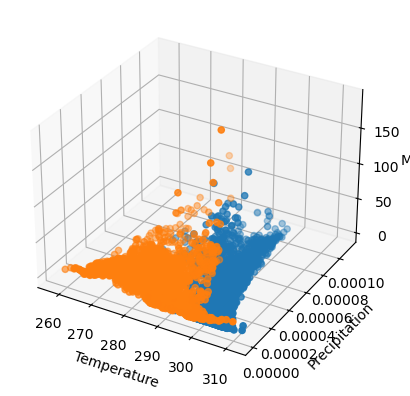

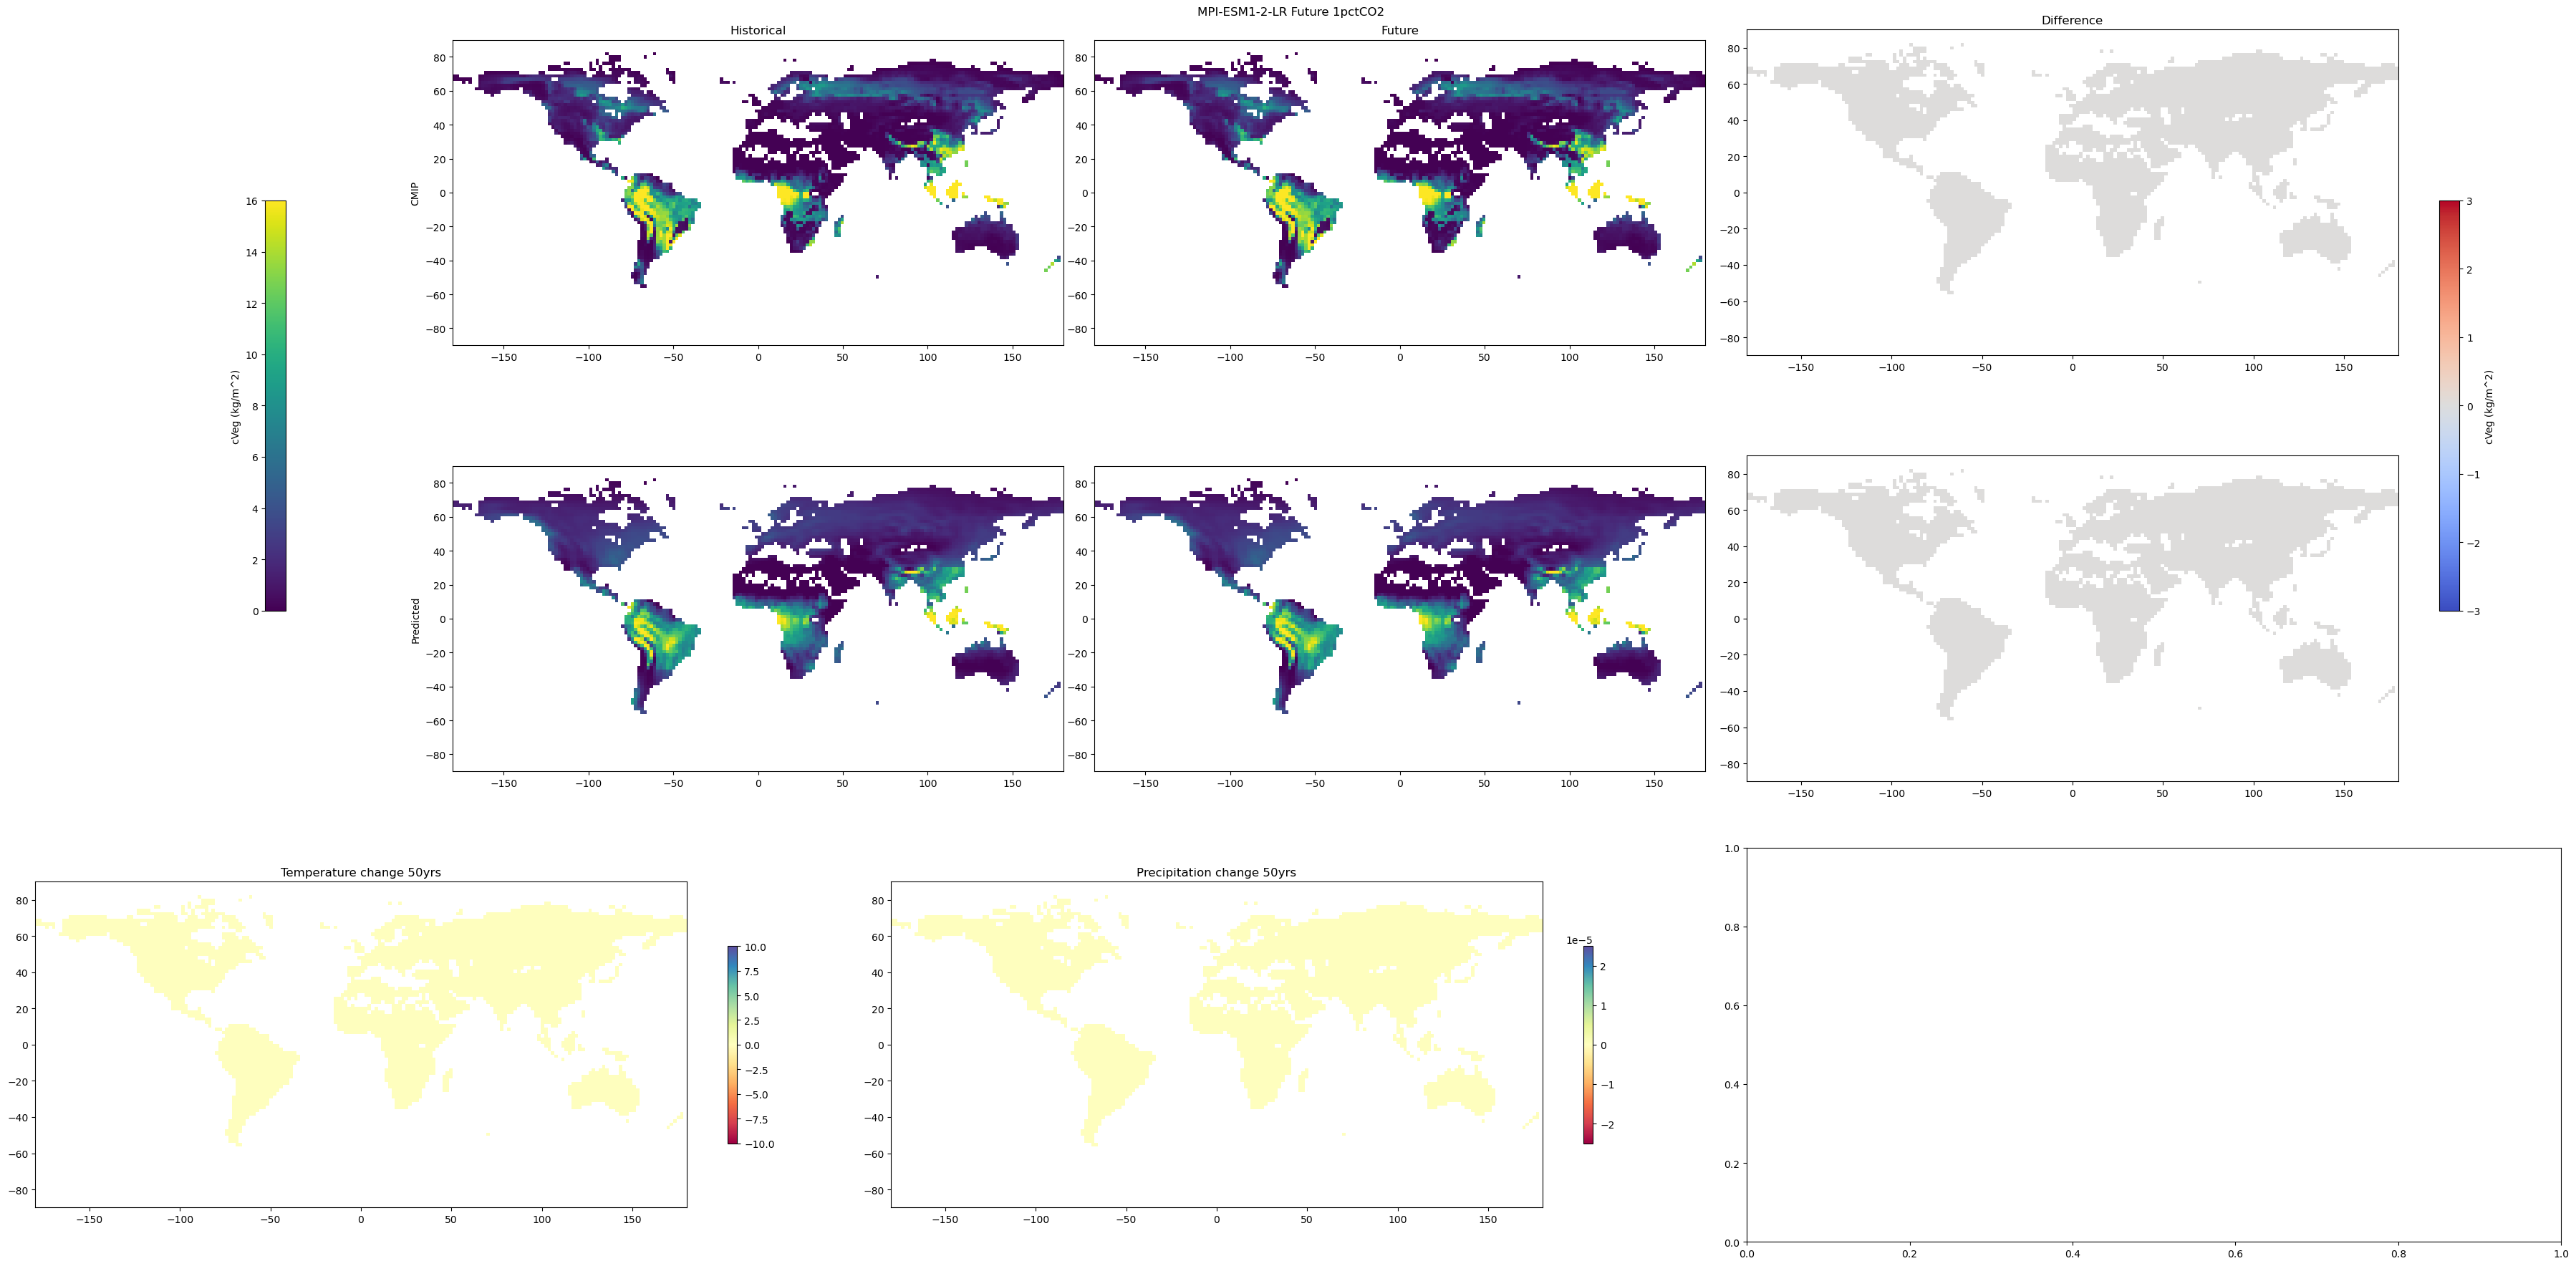

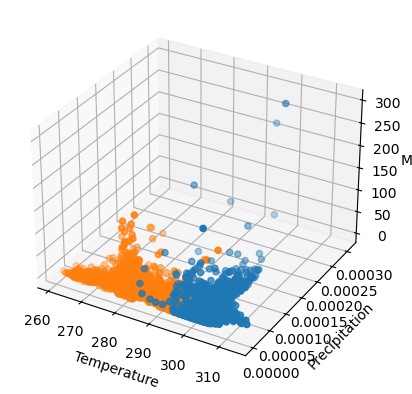

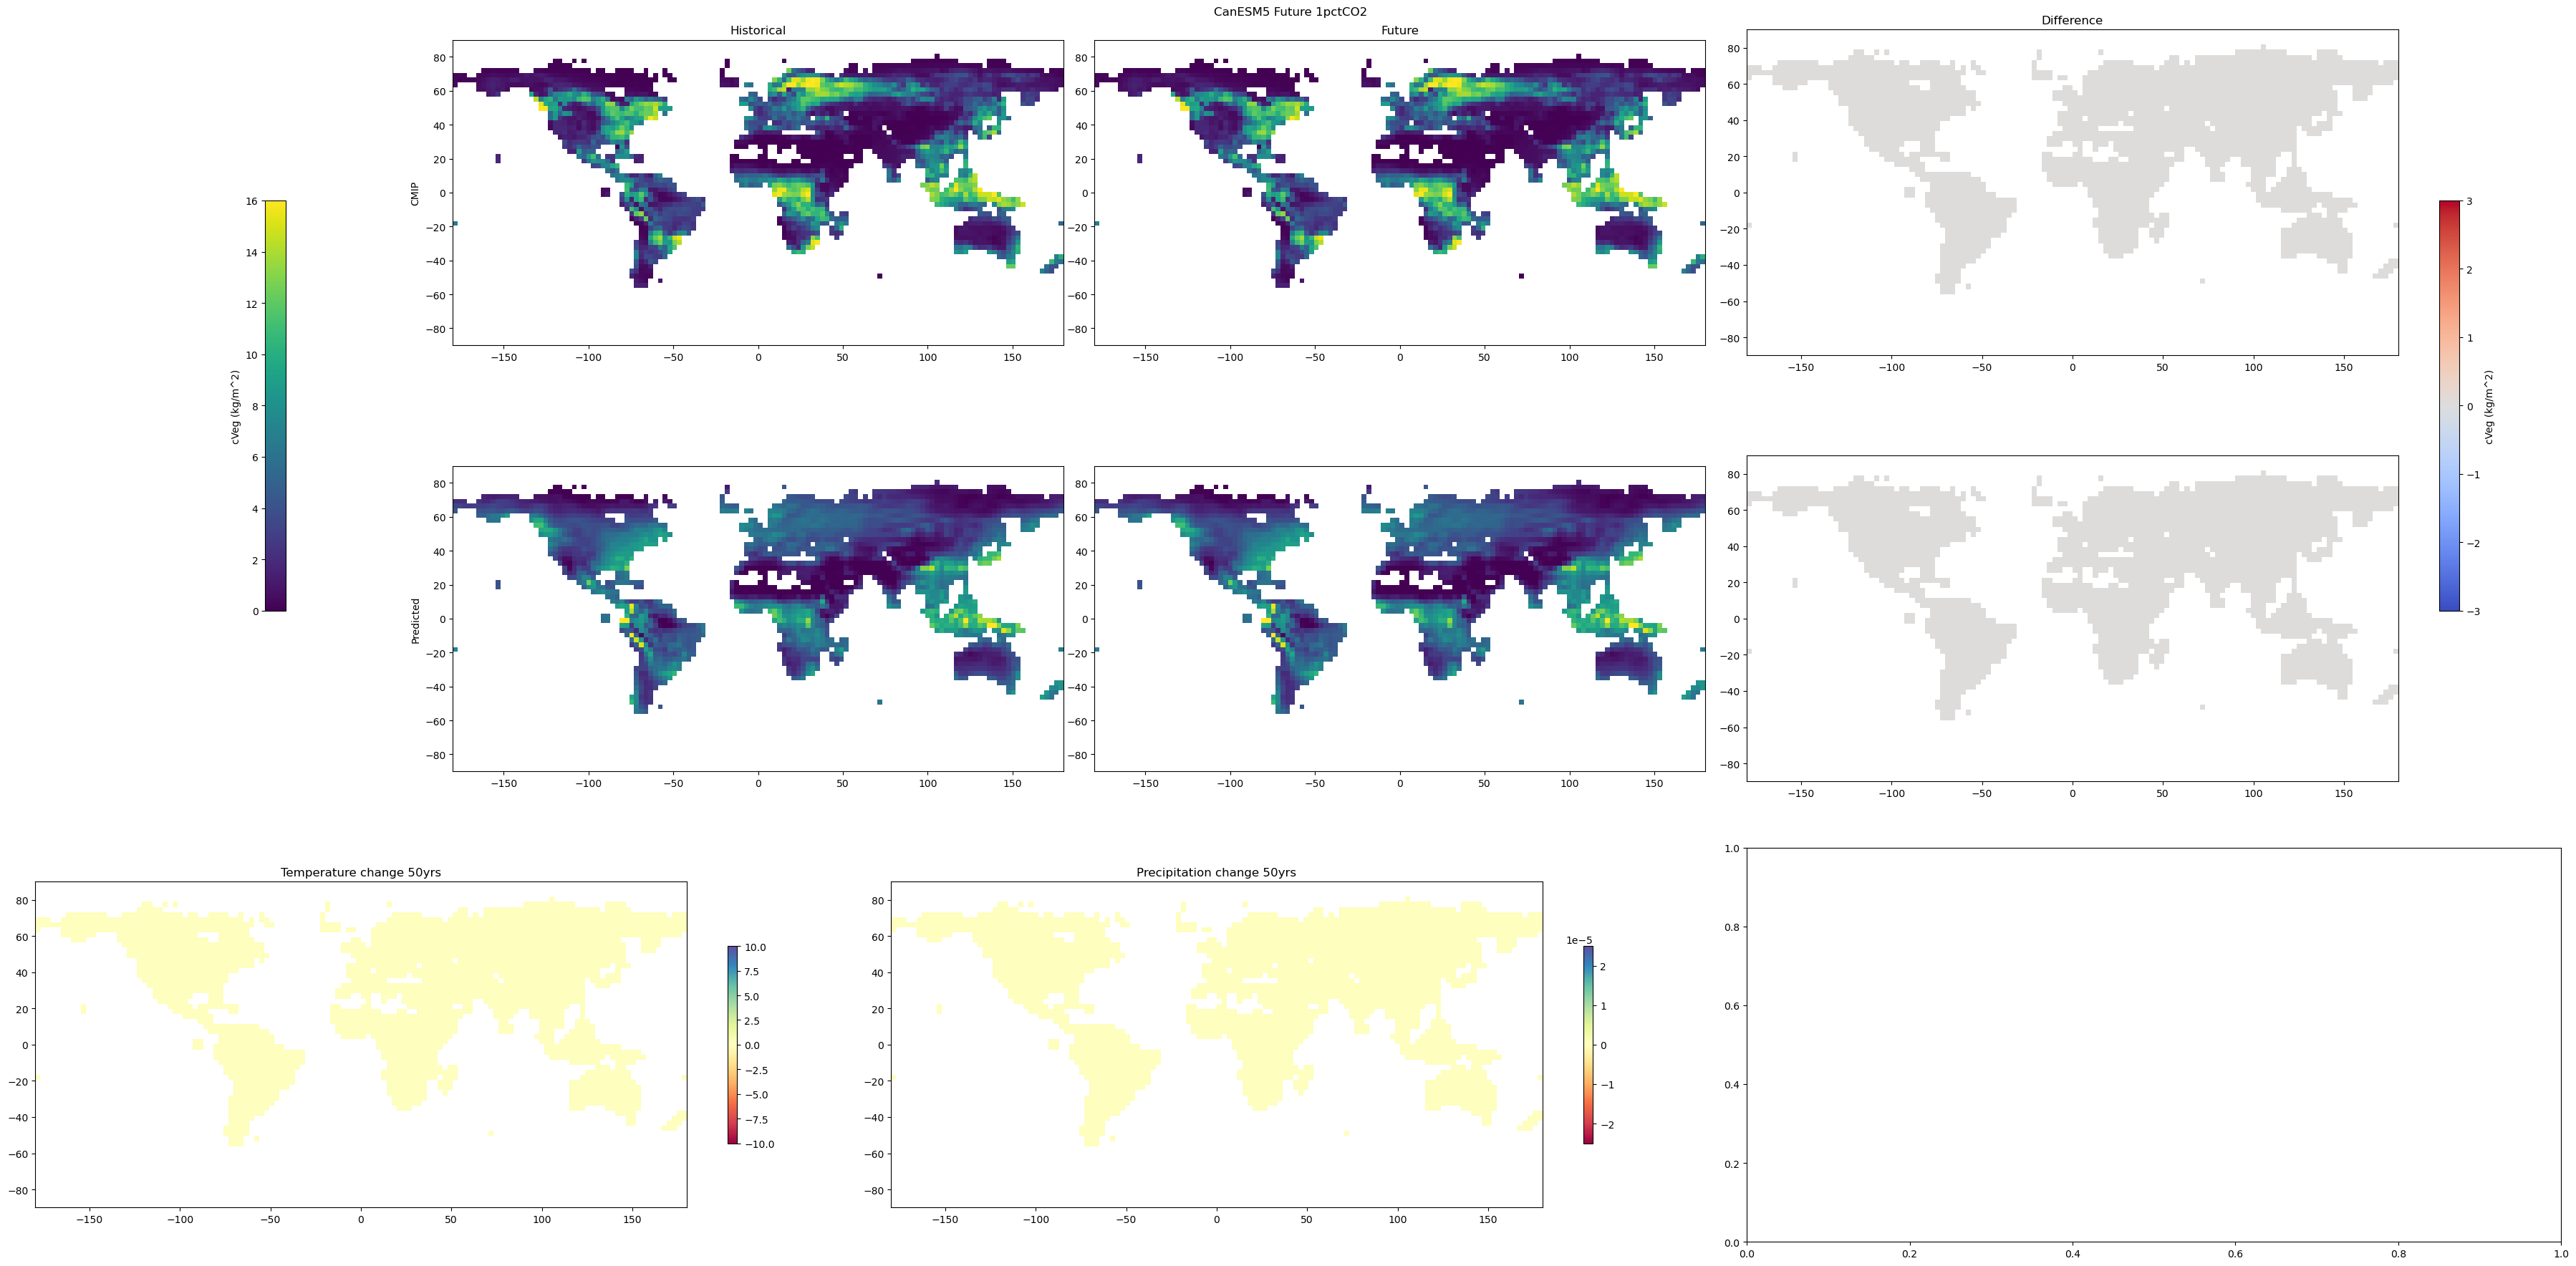

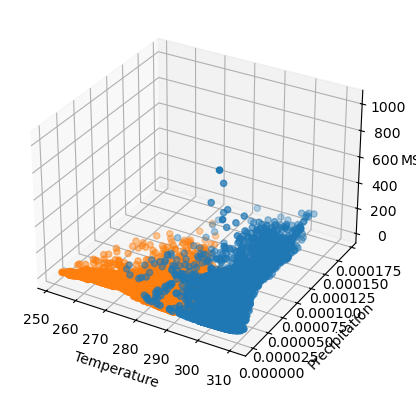

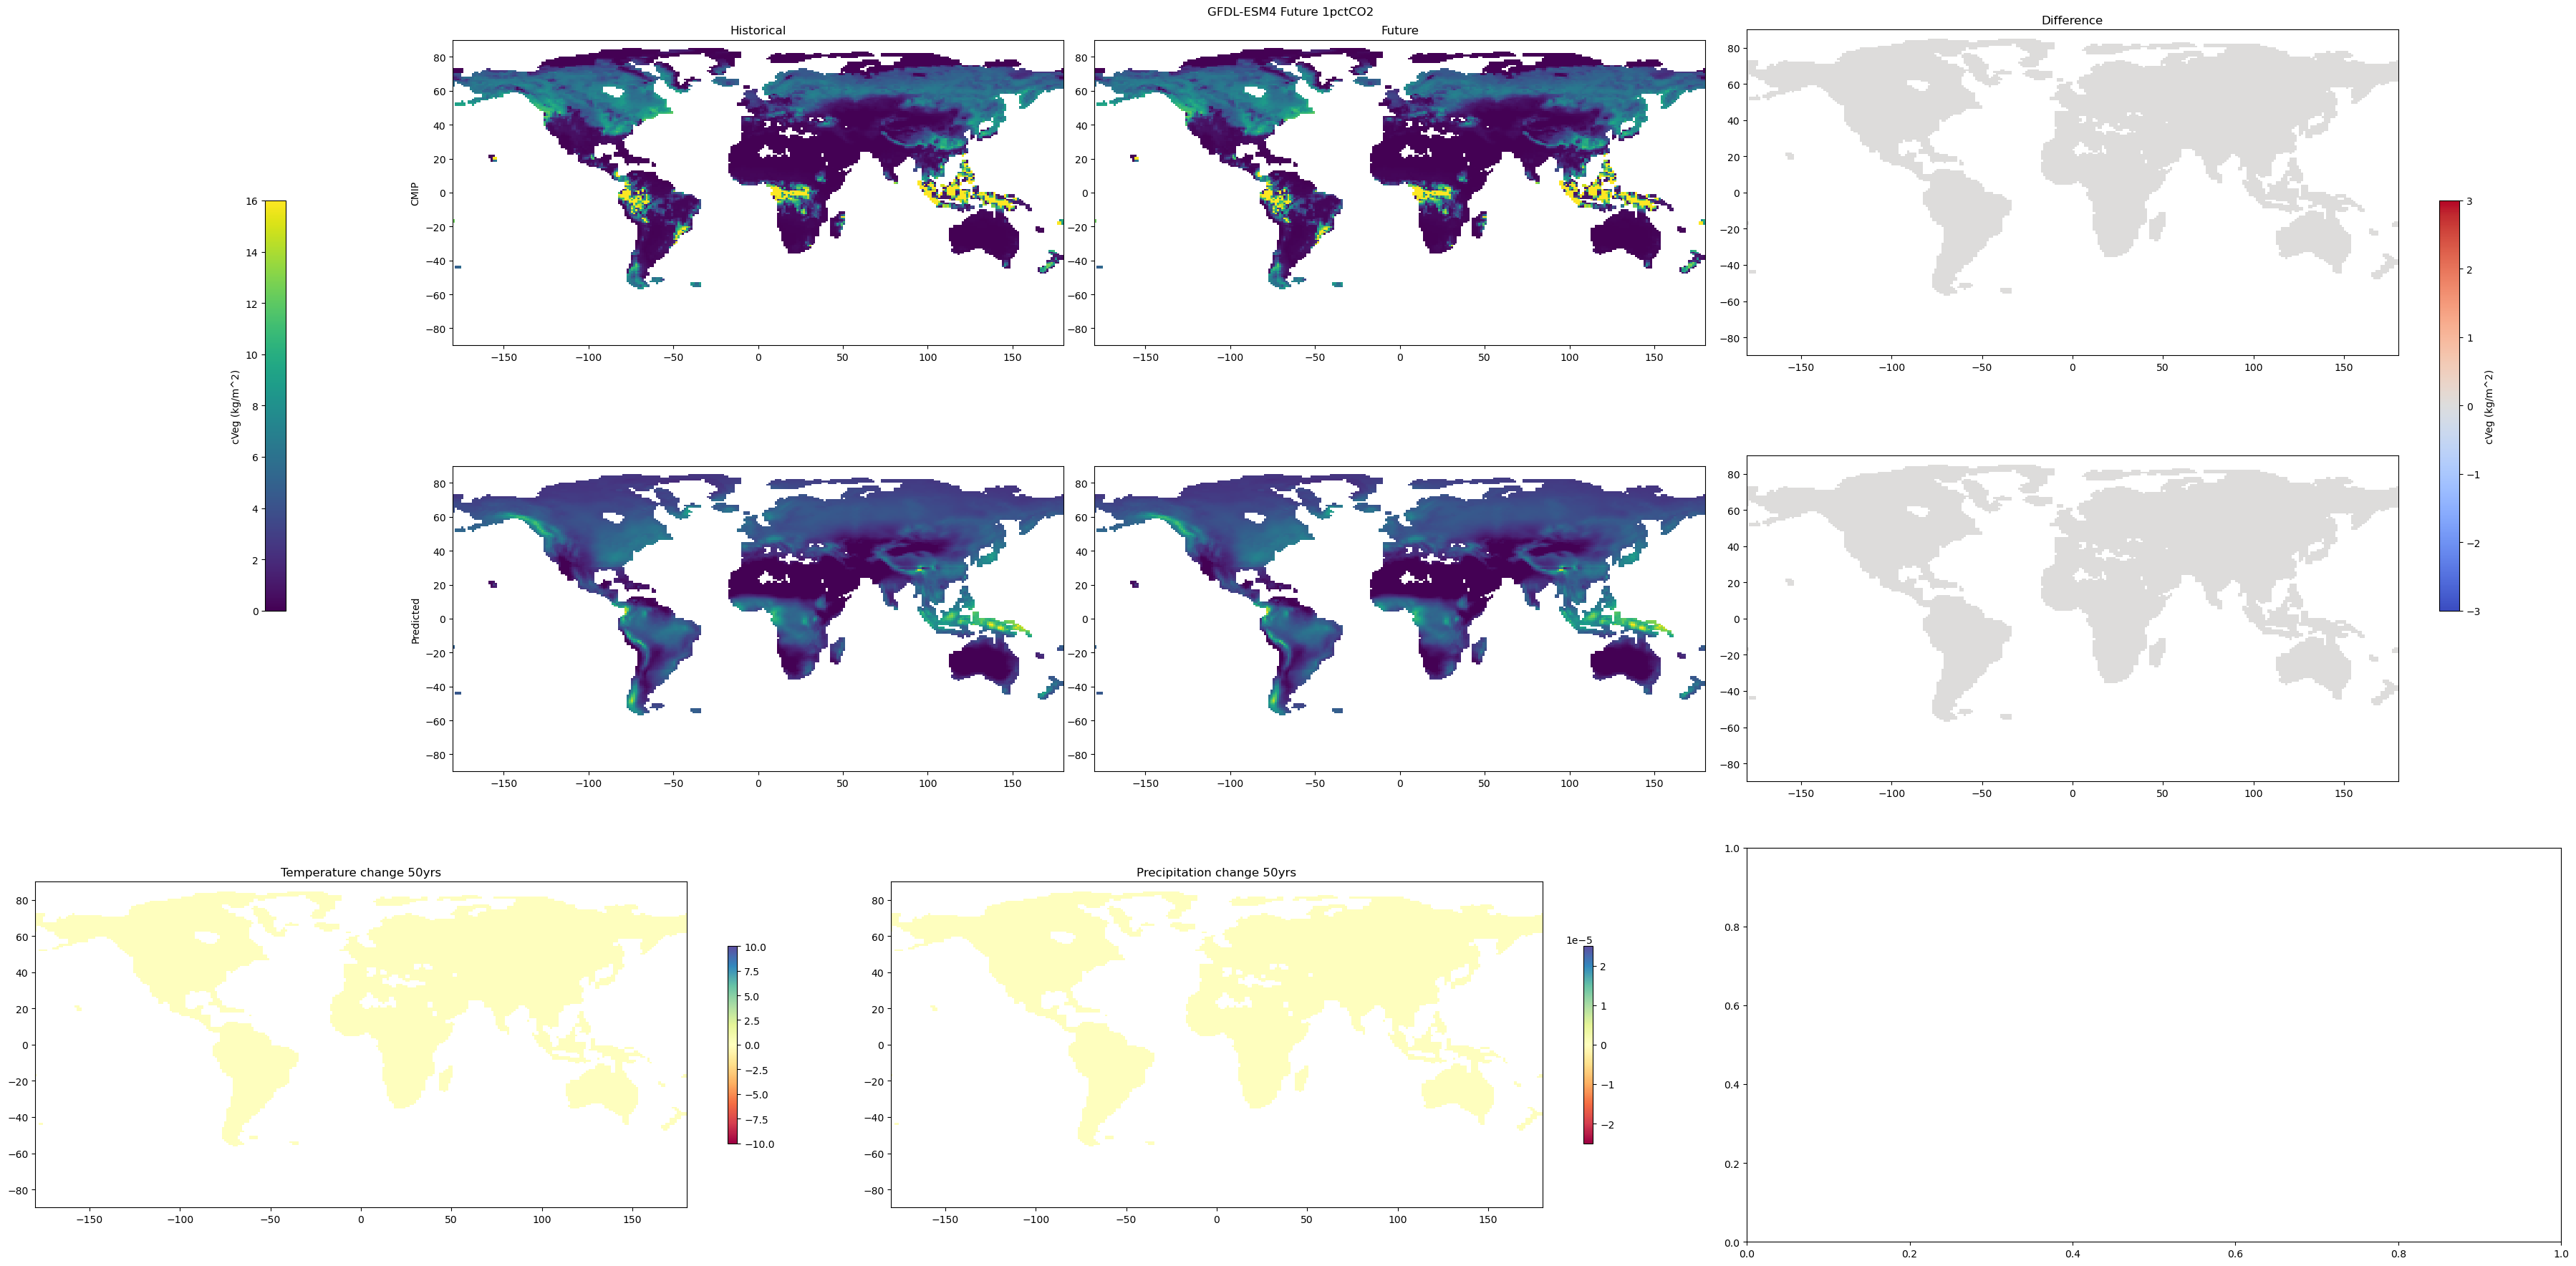

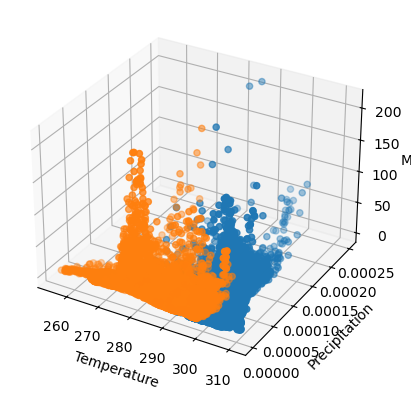

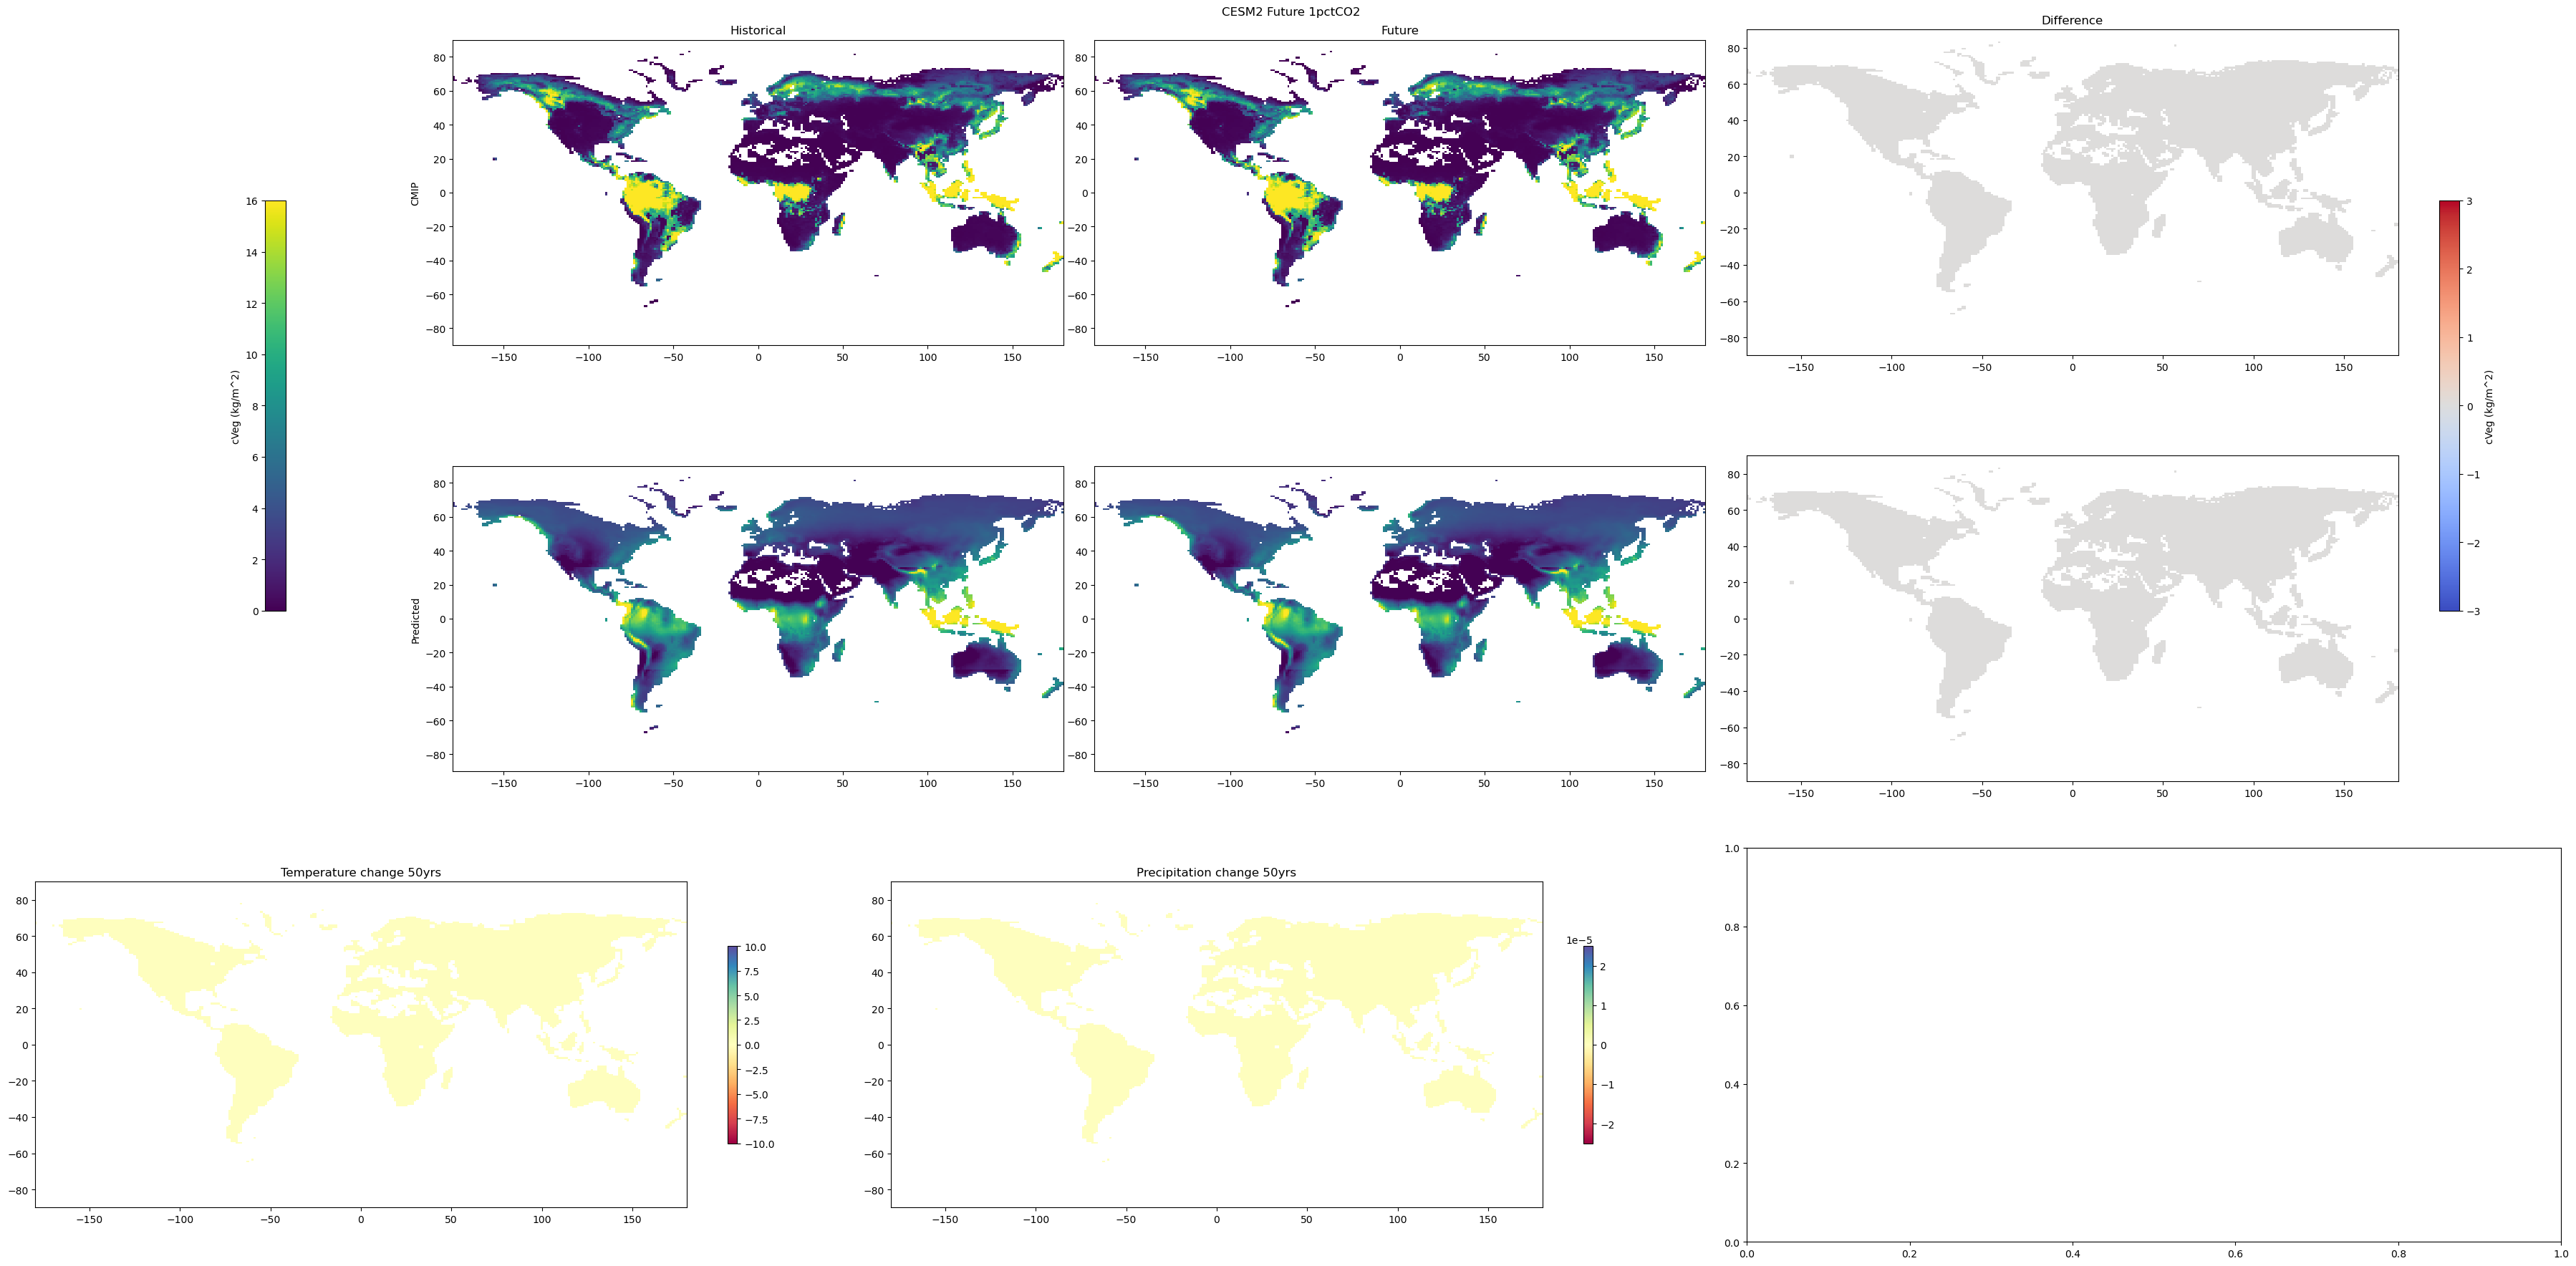

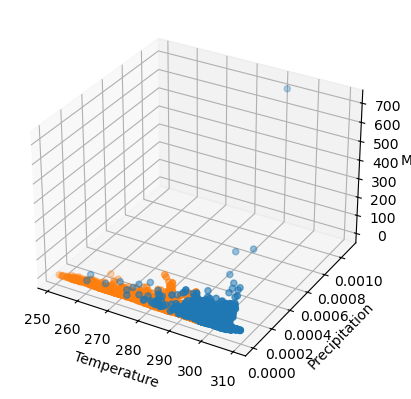

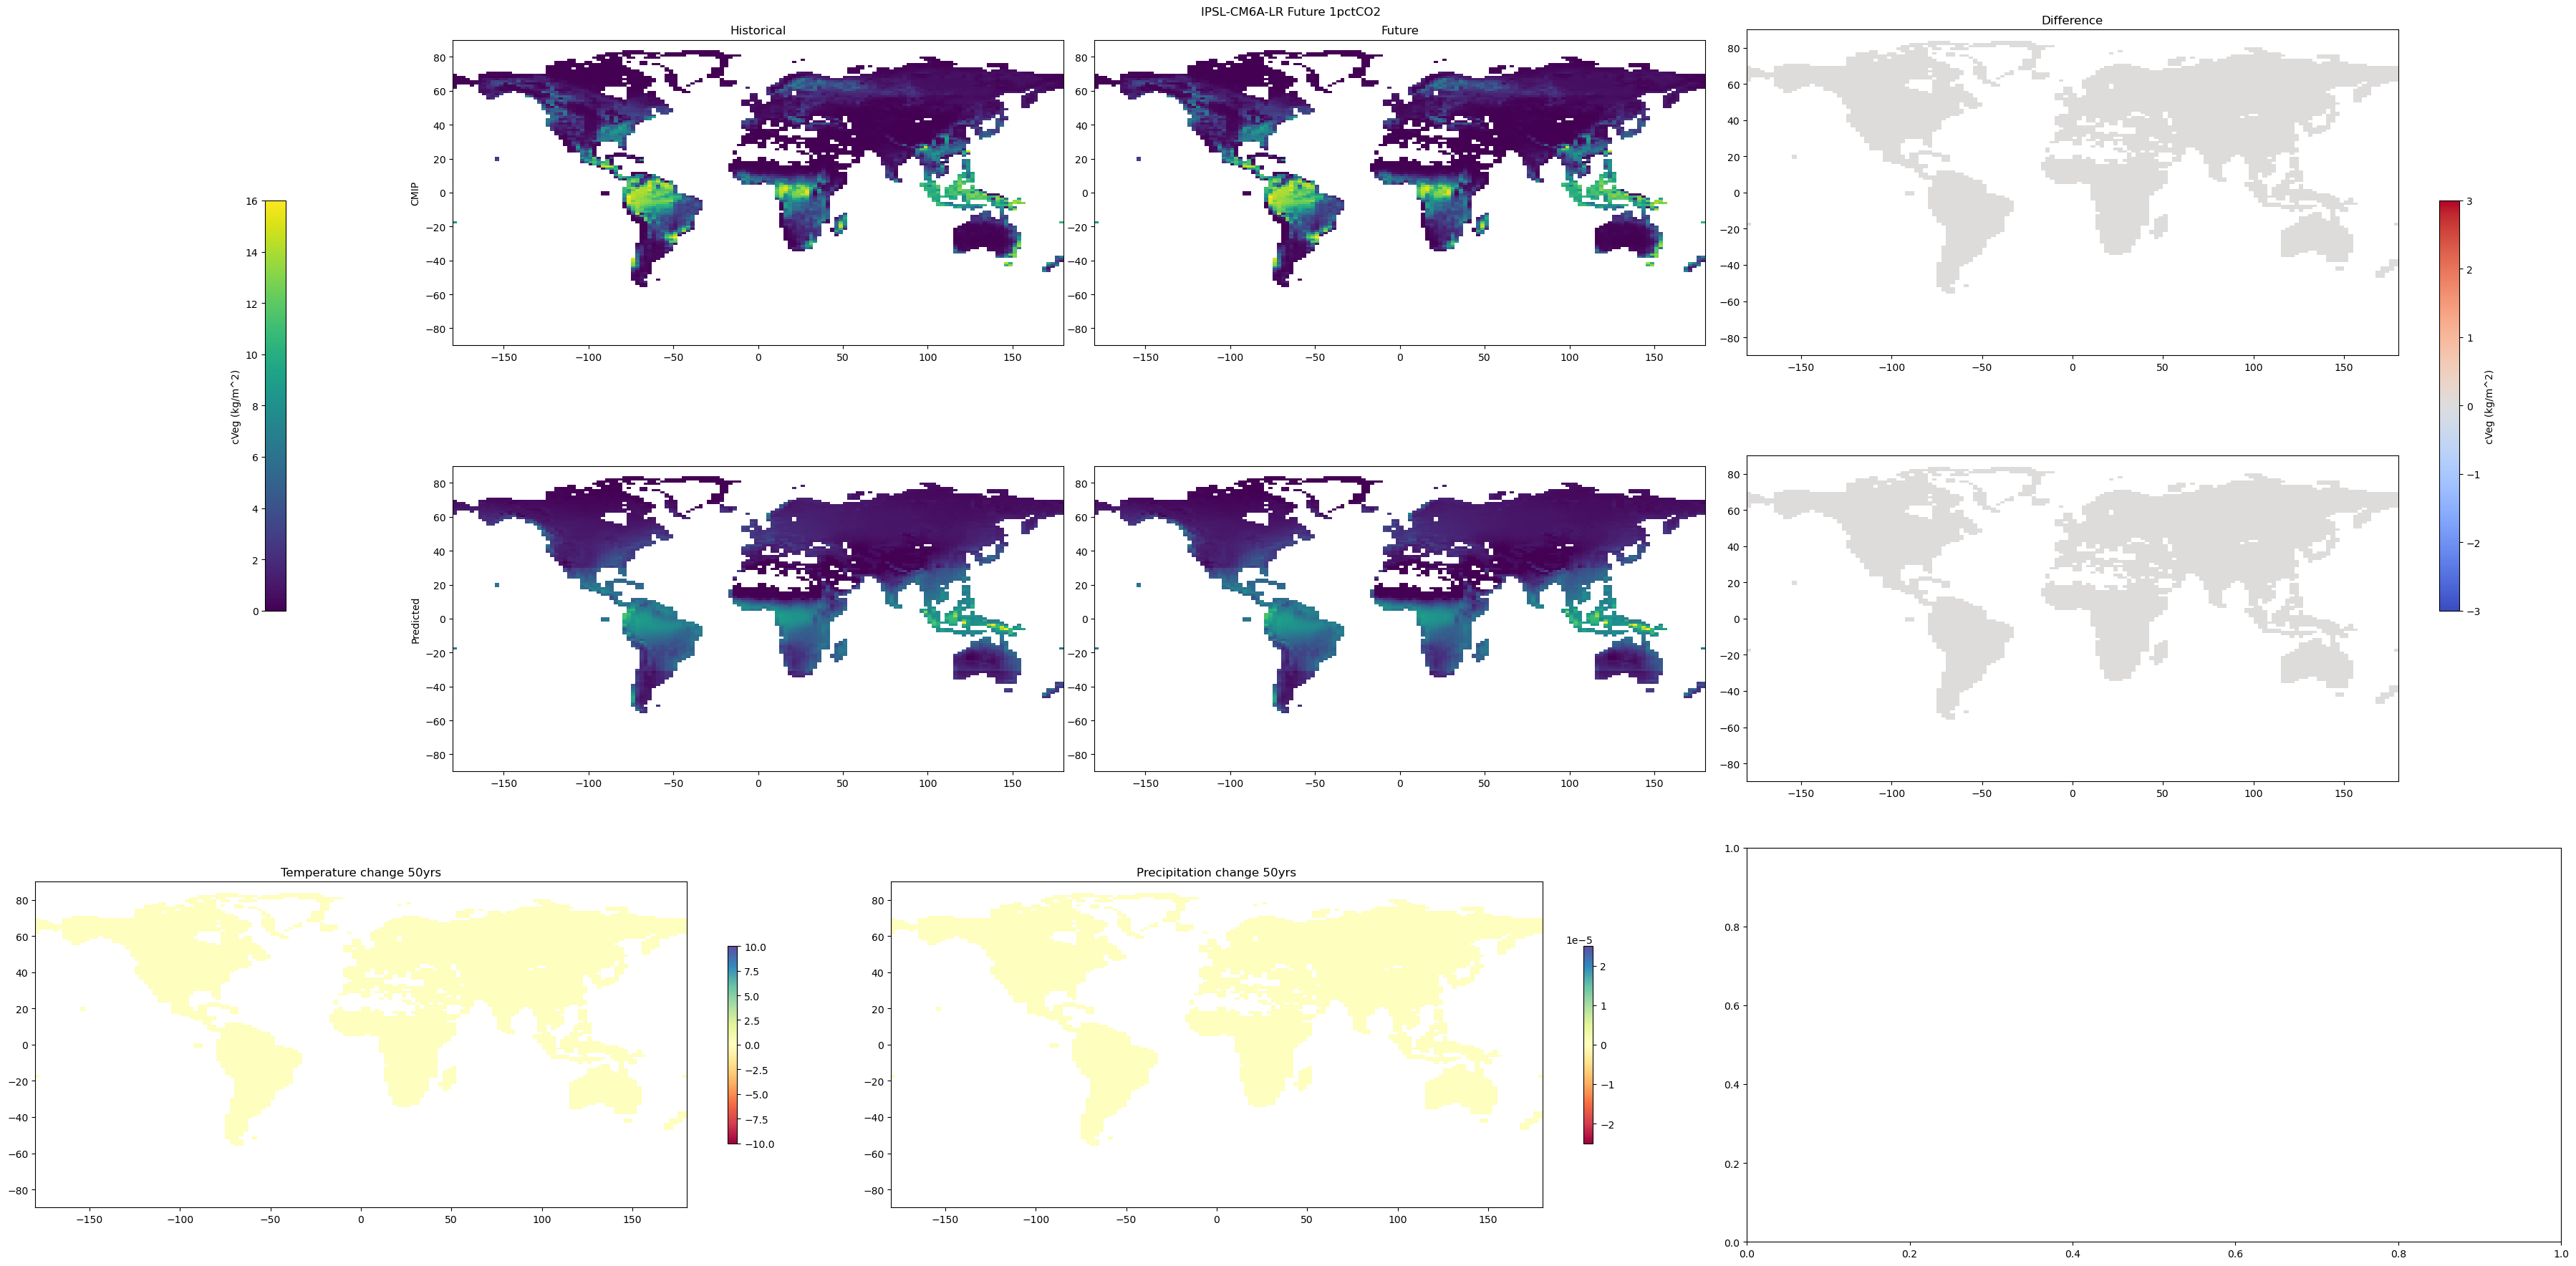

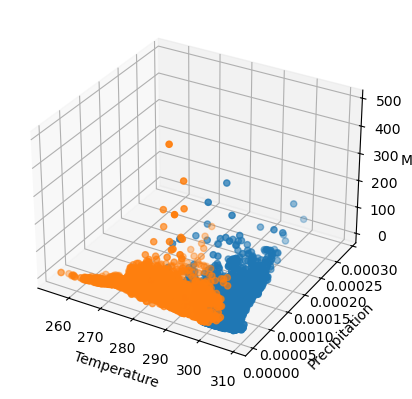

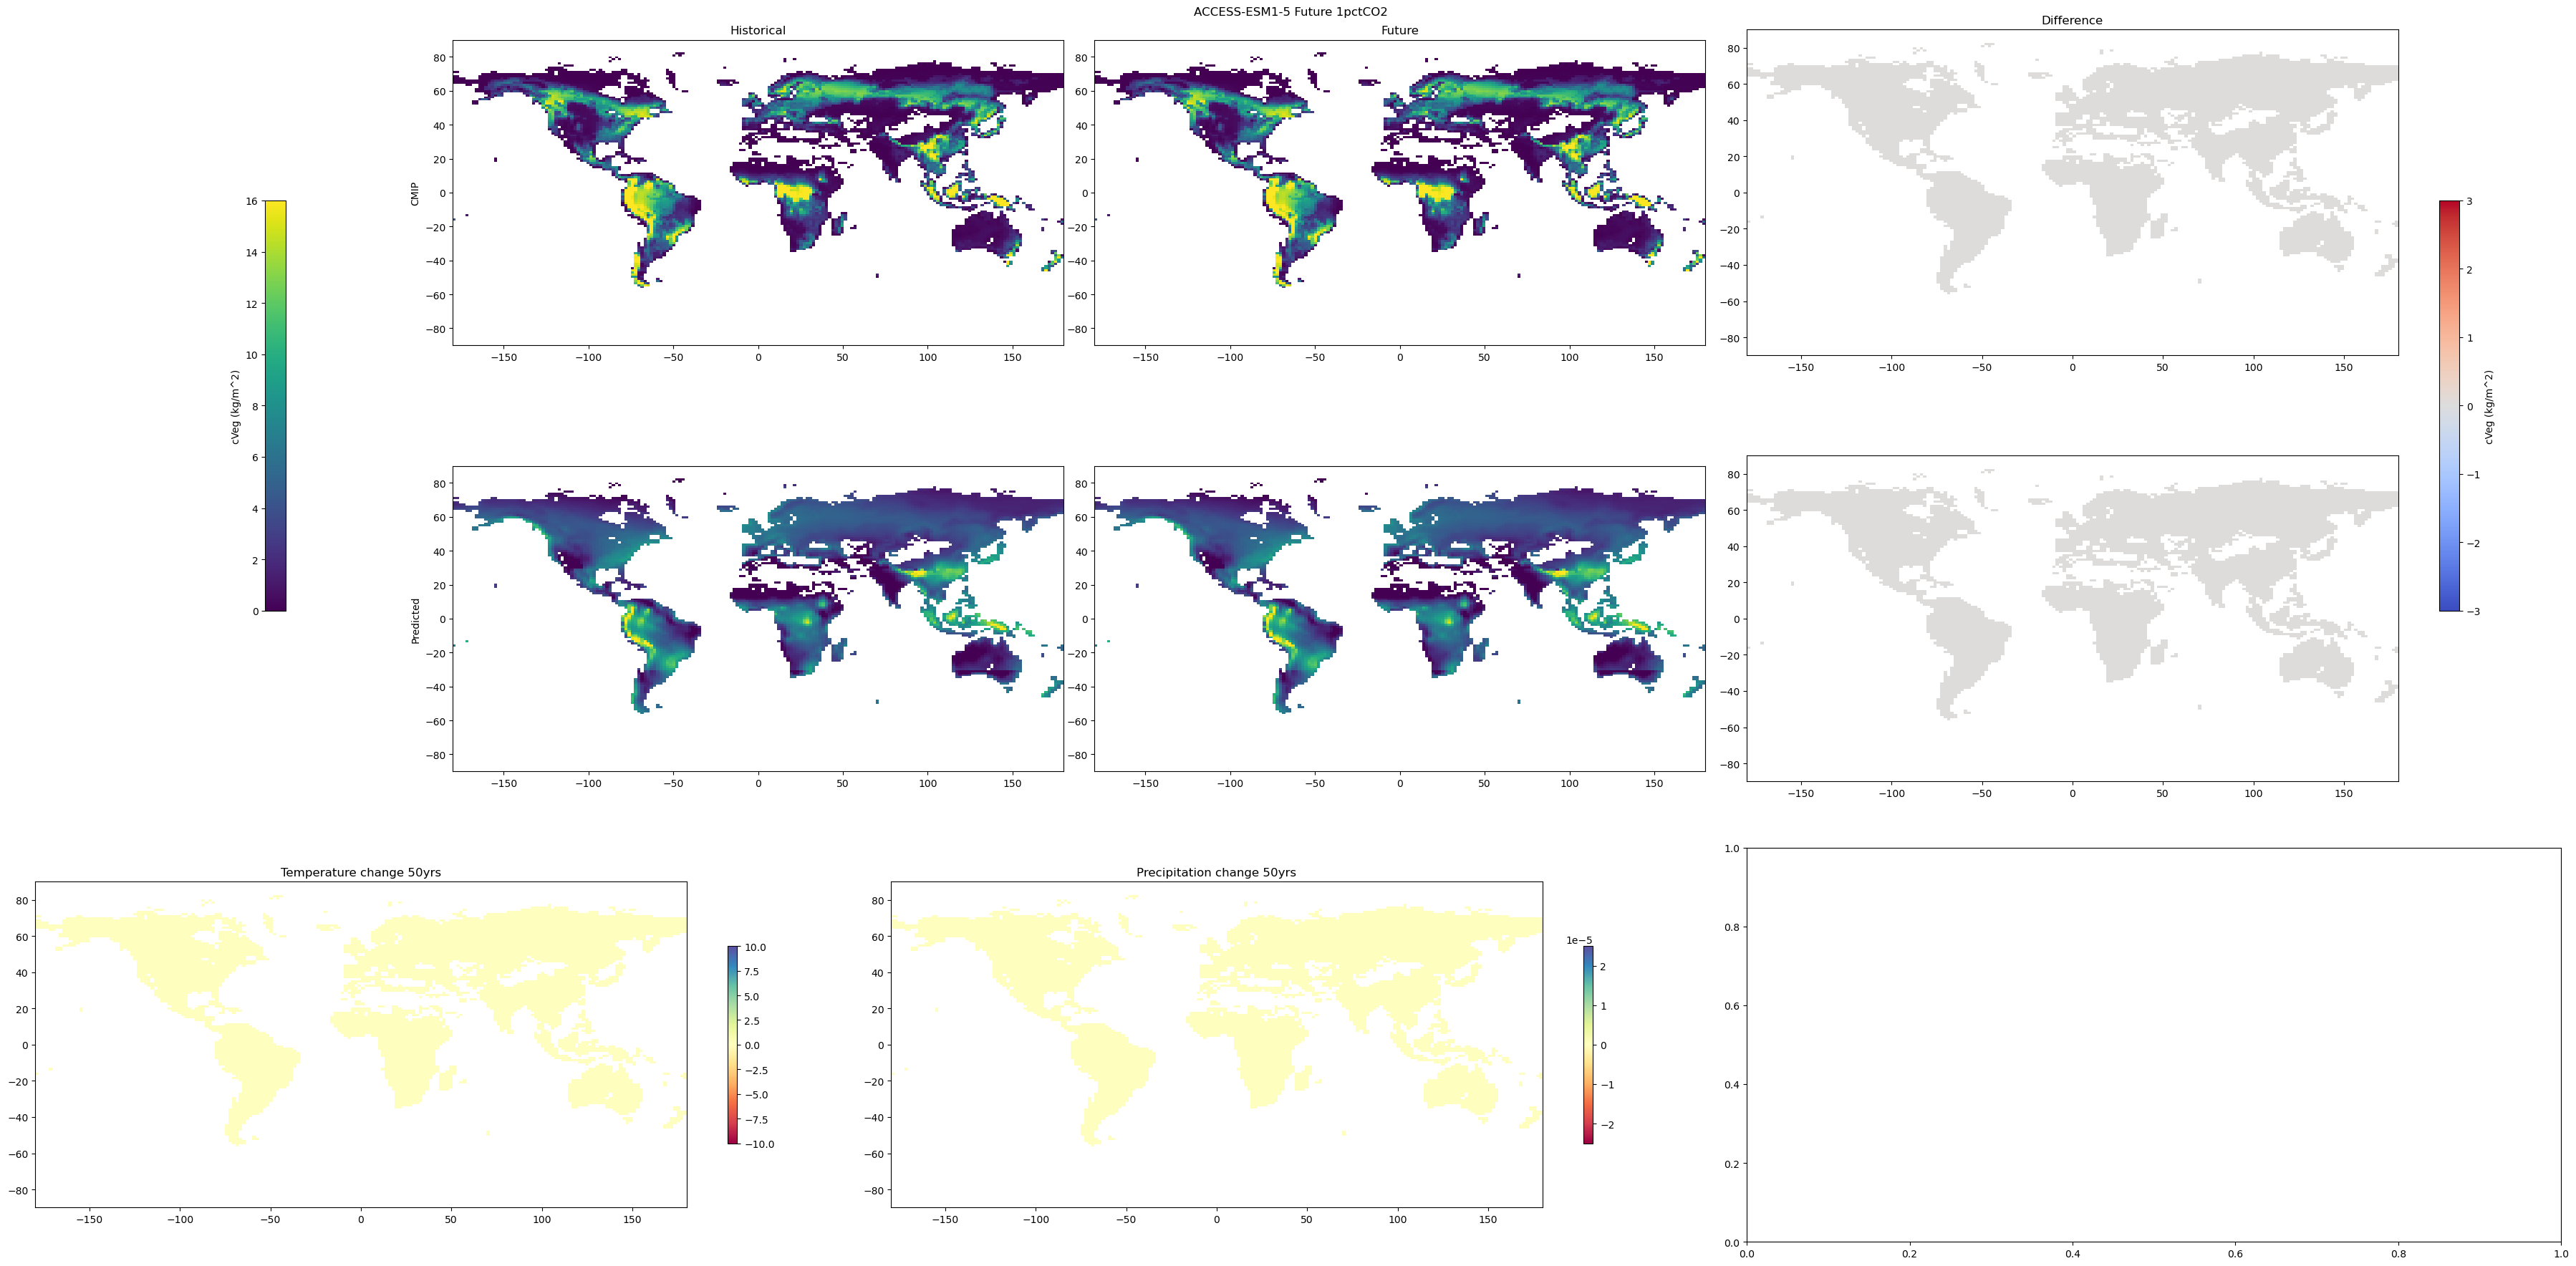

In [10]:
i = 0
exptype = "./1pctCO2-rad/"
for expname in list_experiments(exptype, "hurs"):
    cveg_data = load(exptype, "cVeg", expname)
    pr_data = load(exptype, "pr", expname)
    ts_data = load(exptype, "ts", expname)
    hurs_data = load(exptype, "hurs", expname)
    sn_data = load(exptype, "prsn", expname)
    
    x_cveg = avg20(cveg_data[start_x:end_x,:,:])
    x_ts = avg20(ts_data[start_x:end_x,:,:])
    x_pr = avg20(pr_data[start_x:end_x,:,:])
    x_hurs = avg20(hurs_data[start_x:end_x,:,:])
    x_sn = avg20(sn_data[start_x:end_x,:,:])
    #x_gpp = avg20(gpp_data[start_x:end_x,:,:])
    y_ts = avg20(ts_data[start_y:end_y,:,:])
    y_pr = avg20(pr_data[start_y:end_y,:,:])
    y_hurs = avg20(hurs_data[start_y:end_y,:,:])
    #y_gpp = avg20(gpp_data[start_y:end_y,:,:])
    y_cveg = avg20(cveg_data[start_y:end_y,:,:])
    y_sn = avg20(sn_data[start_y:end_y,:,:])

    x_std = std20(pr_data[start_x:end_x,:,:])
    y_std = std20(pr_data[start_y:end_y,:,:])

    x_vpd = vpd(x_ts, x_hurs)
    y_vpd = vpd(y_ts, y_hurs)

    #plt.figure(i)
    #plt.imshow(x_vpd[::-1], vmin=0, vmax=2.5)
    #plt.colorbar()
    #plt.title("VPD " + expname)
    #plt.savefig("figure_vpd_" + expname + ".png")
    #i += 1

    tropics = np.full([x_cveg.shape[0],x_cveg.shape[1]], False)
    tropics[x_cveg.shape[0]//3:2*x_cveg.shape[0]//3,:] = True

    mask1 = (x_cveg > 0) & tropics
    mask2 = (x_cveg > 0) & ~tropics

    #plt.figure(i)
    #plt.imshow((y_cveg - x_cveg)[::-1], vmin=-2.5, vmax=2.5, cmap="coolwarm")
    #plt.colorbar()
    #plt.savefig("figure_delta50_" + expname + ".png")
    #i += 1
    
    fit_and_test(np.array([y_ts, y_pr, y_vpd, y_sn]), y_cveg, [mask1,mask2], np.array([y_ts, y_pr, y_vpd, y_sn]), y_cveg, expname + " Future 1pctCO2")
    

ACCESS-ESM1-5 1pctCO2
MPI-ESM1-2-LR 1pctCO2
CanESM5 1pctCO2
CMCC-ESM2 1pctCO2
IPSL-CM6A-LR 1pctCO2
CESM2 1pctCO2


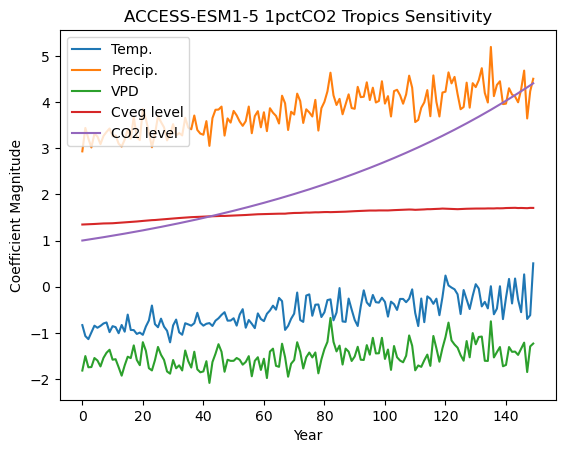

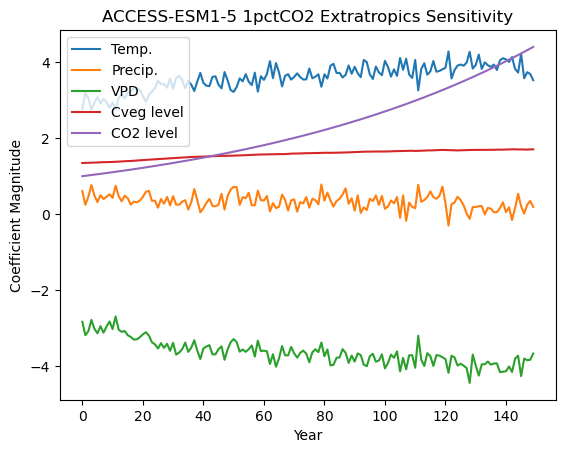

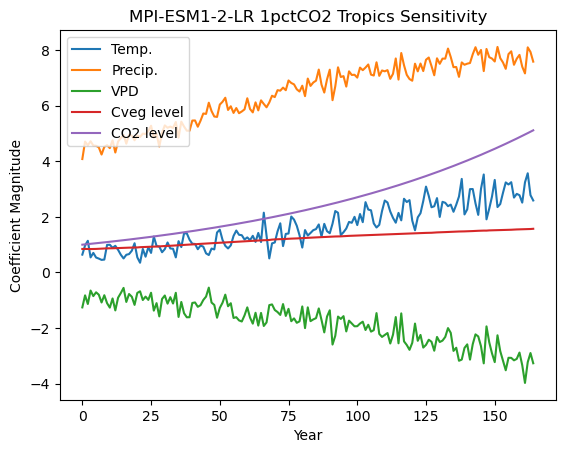

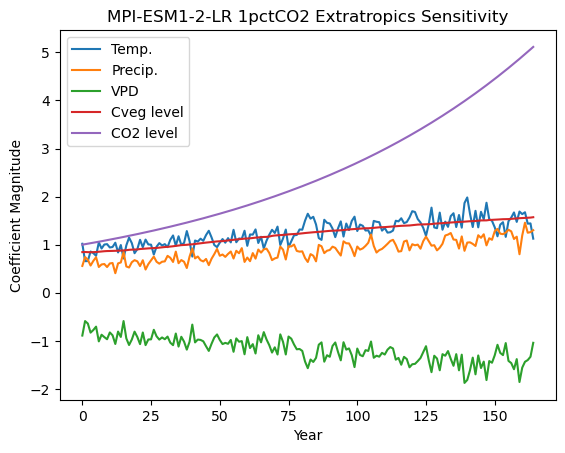

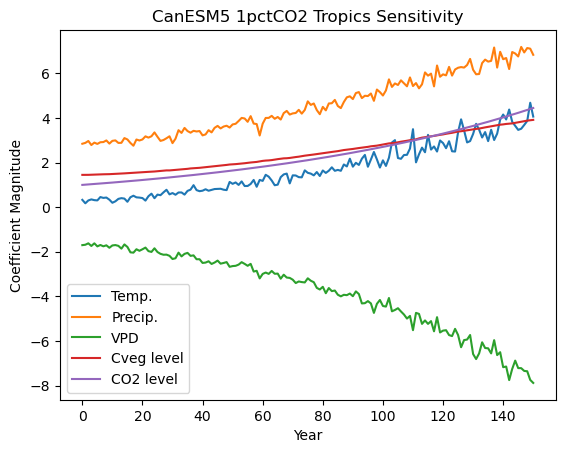

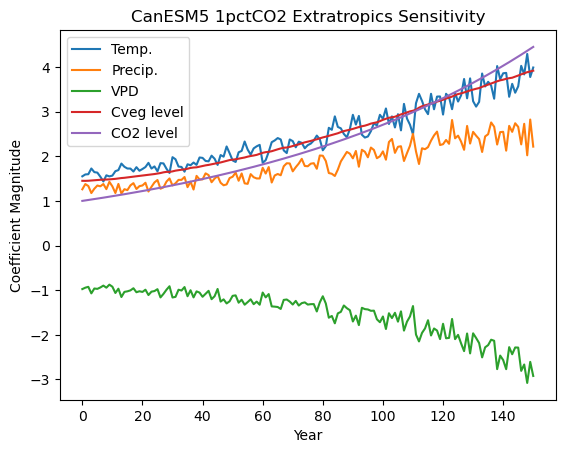

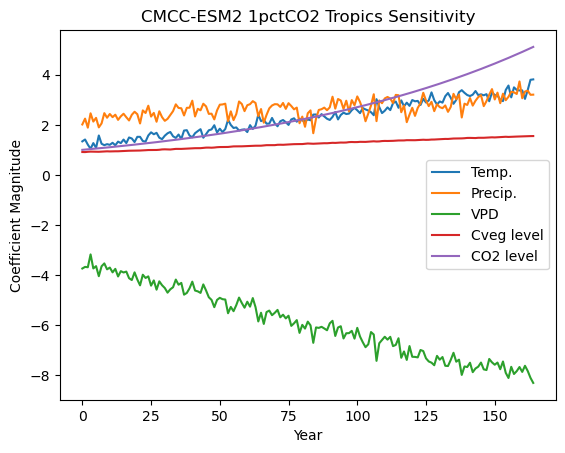

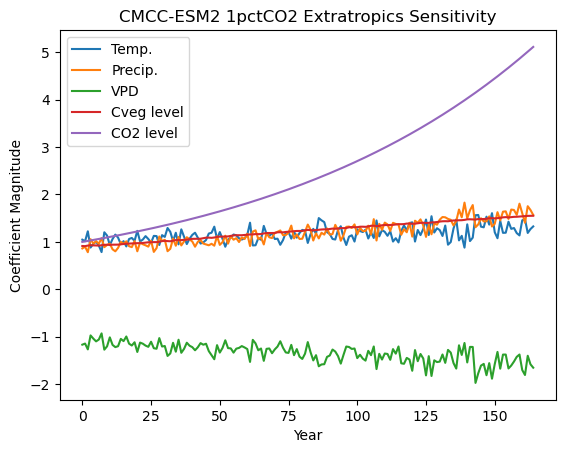

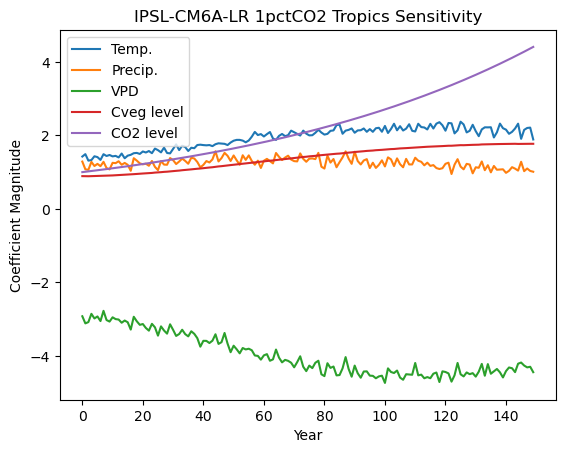

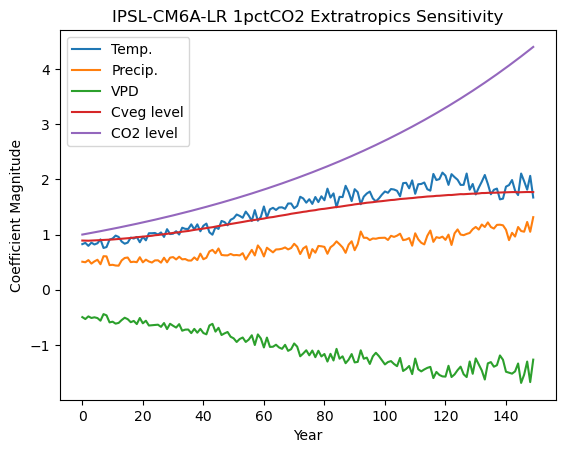

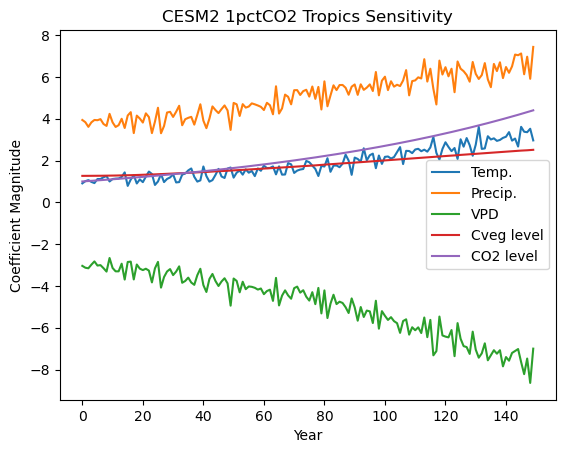

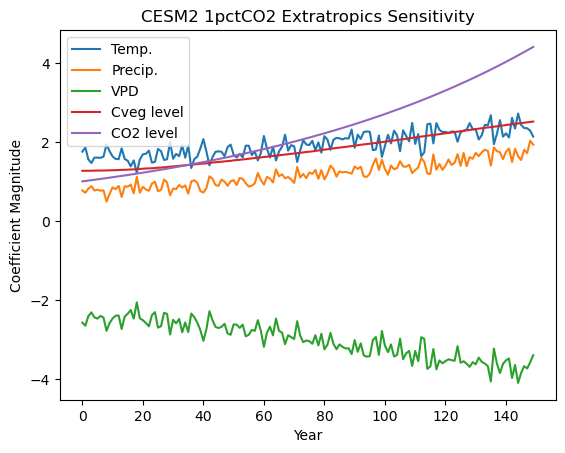

In [12]:
def meanyear(arr):
    layout = arr.shape
    return arr.reshape((layout[0]//12, 12, layout[1], layout[2])).mean(axis=1)

def fastfit(x,y,mask):    
    model_inputs = x[:,mask]#.flatten()
    model_inputs = np.array(model_inputs).transpose()    
    model_output = y[mask].flatten()

    # Fit and score model
    model = LinearRegression()
    model.fit(model_inputs, model_output)

    R2 = model.score(model_inputs, model_output)

    adjusted = [model.coef_[0] * np.std(x[0,mask]), model.coef_[1] * np.std(x[1,mask]), model.coef_[2] * np.std(x[2,mask])]
    return {"x":model.coef_, "X":adjusted, "r2":R2}

        
i = 0
exptype = "./1pctCO2/"

for expname in list_experiments(exptype, "hurs"):
    fullname = expname + " " + exptype.replace("/","").replace(".","")
    print(fullname)
    cveg_data = load(exptype, "cVeg", expname)
    pr_data = load(exptype, "pr", expname)
    ts_data = load(exptype, "ts", expname)
    hurs_data = load(exptype, "hurs", expname)
    vpd_data = vpd(ts_data, hurs_data)
    
    cveg_year = meanyear(cveg_data)
    pr_year = meanyear(pr_data)
    ts_year = meanyear(ts_data)
    vpd_year = meanyear(vpd_data)

    tropic_paths = []
    tropic_r2 = []
    extra_paths = []
    extra_r2 = []
    
    for i in range(cveg_year.shape[0]):
        tropics = np.full([cveg_year[i,:].shape[0],cveg_year[i,:].shape[1]], False)
        tropics[cveg_year[i,:].shape[0]//3:2*cveg_year[i,:].shape[0]//3,:] = True

        mask1 = (cveg_year[i,:] > 0) & tropics
        mask2 = (cveg_year[i,:] > 0) & ~tropics
        
        tropic_results = fastfit(np.array([ts_year[i,:], pr_year[i,:], vpd_year[i,:]]), cveg_year[i,:], mask1)        
        tropic_paths.append(tropic_results["X"])
        tropic_r2.append(tropic_results["r2"])
        extra_results = fastfit(np.array([ts_year[i,:], pr_year[i,:], vpd_year[i,:]]), cveg_year[i,:], mask2)
        extra_paths.append(extra_results["X"])
        extra_r2.append(extra_results["r2"])

    weights = cuts(cveg_year.shape[1],cveg_year.shape[2])
    
    CO2 = 1
    for i in range(cveg_year.shape[0]):
        values = np.nan_to_num(cveg_year[i,:])
        avg_cveg = np.sum(values * weights)
        tropic_paths[i].append(avg_cveg)
        extra_paths[i].append(avg_cveg)
        tropic_paths[i].append(CO2)
        extra_paths[i].append(CO2)
        CO2 *= 1.01

    tropic_paths = np.array(tropic_paths)
    extra_paths = np.array(extra_paths)

    filetropic = "sensitivity_" + fullname.lower().replace(" ","_").replace("-","_") + "_tropic.png"
    fileextra = "sensitivity_" + fullname.lower().replace(" ","_").replace("-","_") + "_extra.png"
    
    plt.figure()
    plt.plot(tropic_paths)
    plt.title(fullname + " Tropics Sensitivity")
    plt.legend(["Temp.", "Precip.", "VPD", "Cveg level", "CO2 level"])
    plt.xlabel("Year")
    plt.ylabel("Coefficient Magnitude")
    plt.savefig(filetropic)
    plt.figure()
    plt.plot(extra_paths)
    plt.title(fullname + " Extratropics Sensitivity")
    plt.legend(["Temp.", "Precip.", "VPD", "Cveg level", "CO2 level"])
    plt.xlabel("Year")
    plt.ylabel("Coefficient Magnitude")
    plt.savefig(fileextra)